In [1]:
import torch
import numpy as np
from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from collections import OrderedDict
import matplotlib.pyplot as plt
import random

## 0 Load pretrained model and dataloaders

In [2]:
ARGS = parse_args()
ARGS.data_root = 'data'
ARGS.data = 'cifar100'
ARGS.save= '/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/models/models'
ARGS.arch = 'msdnet'
ARGS.batch_size = 64
ARGS.epochs = 300
ARGS.nBlocks = 7
ARGS.stepmode = 'even'
ARGS.base = 4
ARGS.nChannels = 16
ARGS.j = 16
ARGS.num_classes = 100
ARGS.step = 2
ARGS.use_valid = True
ARGS.splits = ['train', 'val', 'test']

In [3]:
# load pre-trained model
model = MSDNet(args=ARGS)
MODEL_PATH = 'models/models/save_models/checkpoint_299.pth.tar'
state = torch.load(MODEL_PATH)
params = OrderedDict()
for params_name, params_val in state['state_dict'].items():
    params[params_name.replace('module.', '')] = params_val
    # state['state_dict'][params_name.replace('module.', '')] = state['state_dict'].pop(params_name)
model.load_state_dict(params)
model = model.cuda()
model.eval()

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

MSDNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): MSDNFirstLayer(
        (layers): ModuleList(
          (0): ConvBasic(
            (net): Sequential(
              (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): ConvBasic(
            (net): Sequential(
              (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (2): ConvBasic(
            (net): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [4]:
# data
_, _, test_loader = get_dataloaders(ARGS)

logits = []
targets = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y = y.cuda(device=None)
        x = x.cuda()

        input_var = torch.autograd.Variable(x)
        target_var = torch.autograd.Variable(y)

        output = model(input_var)
        if not isinstance(output, list):
            output = [output]

        logits.append(torch.stack(output))
        targets.append(target_var)

logits = torch.cat(logits, dim=1).cpu()
targets = torch.cat(targets).cpu()

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Load train_set_index !!!!!!


### unit-testing

In [63]:
L = len(logits)
a = torch.softmax(logits, dim=2)
a_cumsum = a.cumsum(dim=0)
a_cumsum_mean = a.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]

n = 7390
c = 77

tmp = 0
for i in range(7):
    tmp += a[i, n, c]
    assert np.isclose(a_cumsum[i, n, c], tmp)
    assert np.isclose(a_cumsum_mean[i, n, c], (tmp / (i + 1)))
    # print(tmp, tmp / (i + 1))

## 1 Softmax

### 1.1 anytime-prediction: performance

In [5]:
L = len(logits)

In [6]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]

In [7]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [8]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

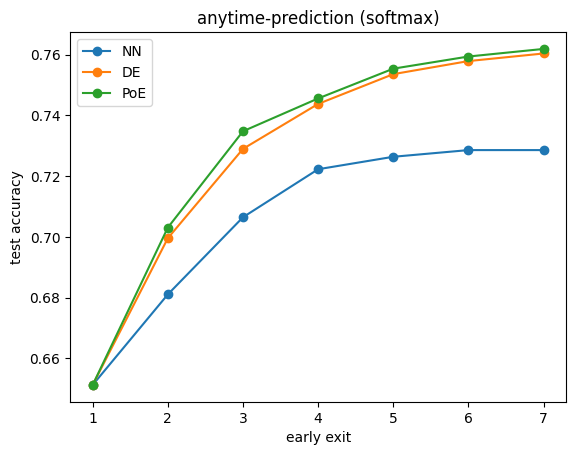

In [9]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc, label='NN', marker='o')
plt.plot(early_exits, acc_de, label='DE', marker='o')
plt.plot(early_exits, acc_poe, label='PoE', marker='o')
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

### 1.2 anytime-prediction: modal probability 

#### 1.2.1 plots

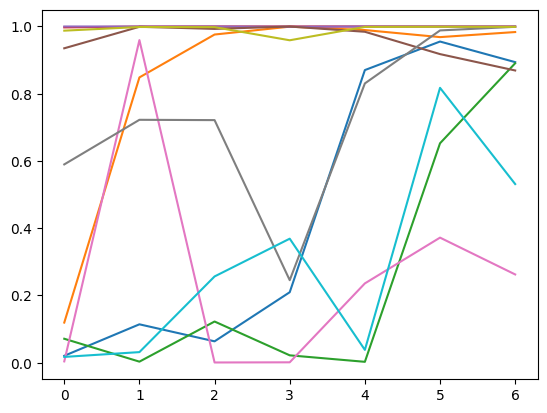

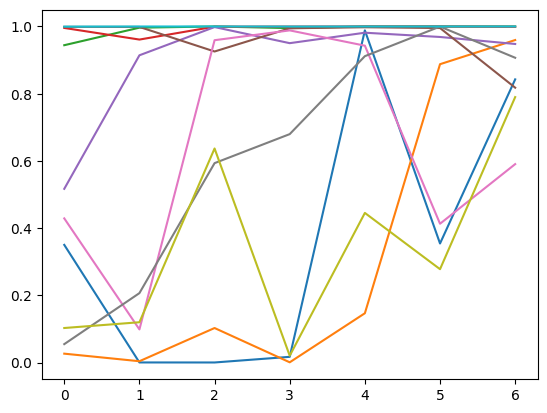

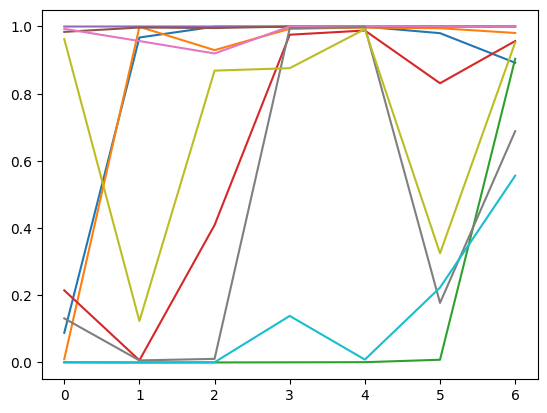

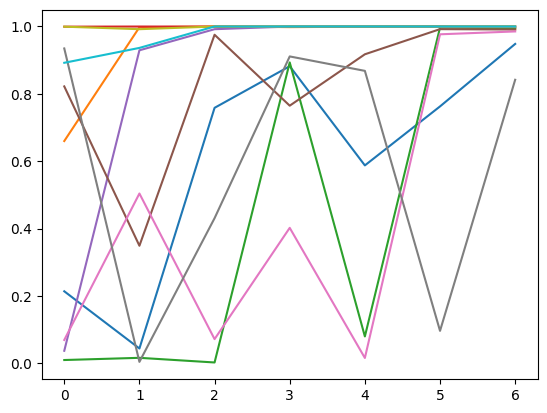

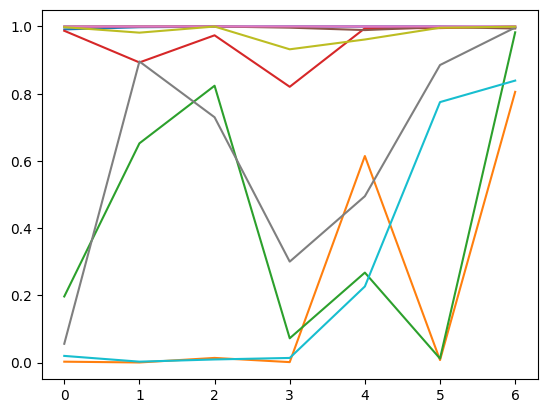

In [10]:
_preds = preds[L - 1]  # modal pred
_probs = probs

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(len(probs_i))), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.2 nr. of test examples with non-decreasing modal probabilities throughout sequential evaluation

In [32]:
# nr. of non-decreasing probability vectors in anytime-prediction regime
def modal_probs_non_decreasing(_preds, _probs, layer):
    nr_non_decreasing = {-0.01: 0, -0.05: 0, -0.1: 0, -0.2: 0, -0.5: 0}
    diffs = []
    for i in range(10000):
        probs_i = _probs[:, i, _preds[layer - 1][i]].cpu().numpy()
        diffs_i = np.diff(probs_i)
        diffs.append(diffs_i.min())
        for threshold in nr_non_decreasing.keys():
            if np.all(diffs_i >= threshold):
                nr_non_decreasing[threshold] += 1
    # print(nr_non_decreasing)
    # print(np.mean(diffs))
    return {-1. * k: ((10000 - v) / 10000) * 100 for k, v in nr_non_decreasing.items()}

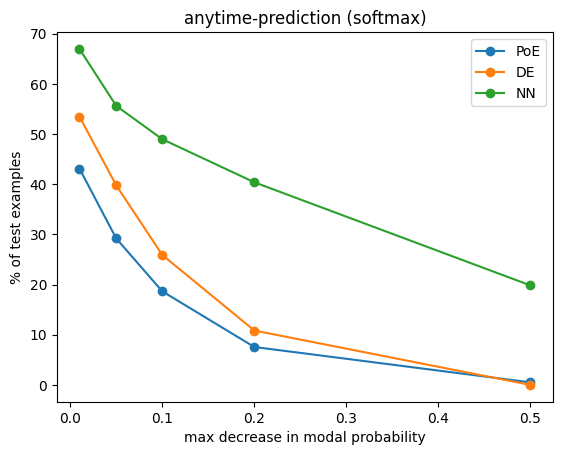

In [33]:
for _preds, _poe, label in [(preds_poe, probs_poe, 'PoE'), (preds_de, probs_de, 'DE'), (preds, probs, 'NN')]:
    modal_probs = modal_probs_non_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in modal probability')
plt.ylabel('% of test examples')
plt.show()

## 2 OVR

In [16]:
def ovr_likelihood(tensor: torch.Tensor) -> torch.tensor:
    # TODO: implement without for loops
    assert len(tensor.shape) == 3  # (L, N_test, C)
    for l in range(tensor.shape[0]):
        for n in range(tensor.shape[1]):
            ovr_mask = tensor[l, n, :] > 0
            tensor[l, n, :] = ovr_mask.long() / ovr_mask.sum()
    return tensor


def f_probs_ovr_poe(tensor: torch.Tensor) -> torch.tensor:
    # TODO: implement without for loops
    assert len(tensor.shape) == 3  # (L, N_test, C)
    tensor = tensor.cumprod(dim=0)
    for l in range(tensor.shape[0]):
        for n in range(tensor.shape[1]):
            ovr_mask = tensor[l, n, :] > 0
            if ovr_mask.sum() > 0:
                tensor[l, n, :] = ovr_mask.long() / ovr_mask.sum()
    return tensor

In [24]:
probs_ovr = ovr_likelihood(logits)
probs_ovr_poe = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_ovr_poe, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

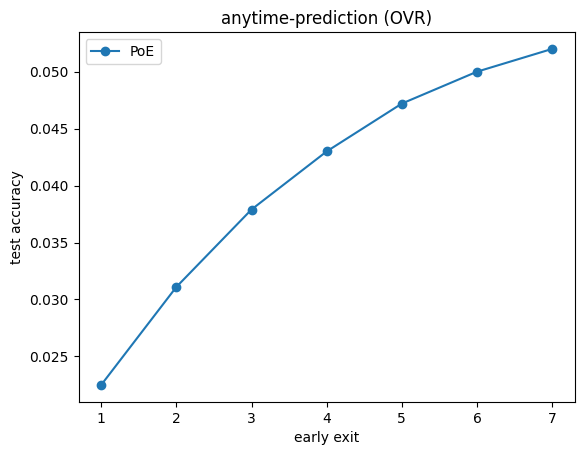

In [25]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

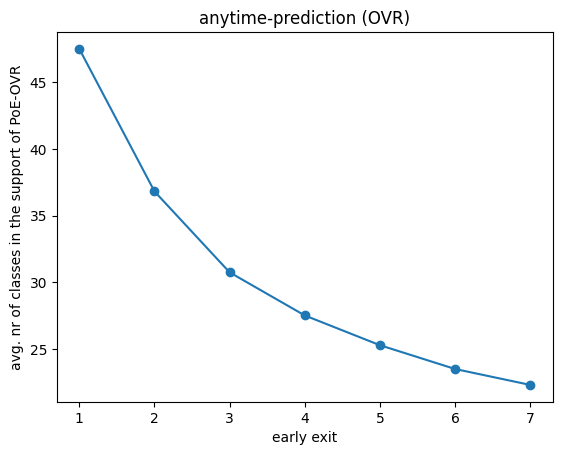

In [19]:
plt.plot(list(range(1, L + 1)), [np.mean((probs_ovr_poe[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o')
plt.title('anytime-prediction (OVR)')
plt.ylabel('avg. nr of classes in the support of PoE-OVR')
plt.xlabel('early exit')
plt.show()

In [37]:
modal_probs_ovr = modal_probs_non_decreasing(preds_poe_ovr, probs_ovr_poe, L)
for thres, val in modal_probs_ovr.items():
    print(thres, val)

0.01 0.0
0.05 0.0
0.1 0.0
0.2 0.0
0.5 0.0
